In [98]:
from datagen.data_generate_ode import rk45
from systems.odes import lorenz
from utils.normalisation import normalise_arrays
from estimators.volt_funcs import Volterra
from estimators.volt_opt_funcs import VolterraOptimisation
from utils.errors import calculate_specdensloss
from utils.plotting import plot_data

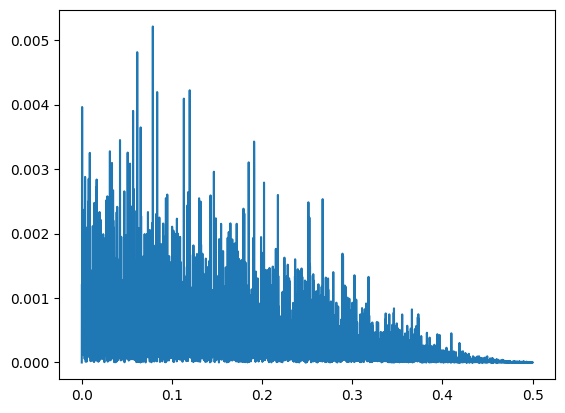

In [159]:
import numpy as np
from math import pi, cos
import matplotlib.pyplot as plt
from scipy.signal import periodogram, welch

theta = 0.9
z = np.random.normal(size=10001)
x = [z[t] + theta*z[t-1] for t in range(1, len(z))]

freq, psd = periodogram(x, scaling="spectrum")

plt.plot(freq, psd)
plt.show()

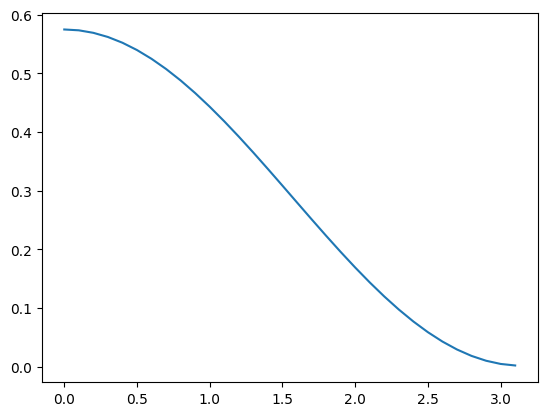

In [151]:

def spec_dens(freq):
    return 1/(2*pi) * (1 + 1.8 * cos(freq) + 0.81)
freq_range = np.arange(0, pi, 0.1)

plt.plot(freq_range, [spec_dens(freq) for freq in freq_range])

[0.018335512395619973, 0.021709566644593985, 0.010084481079962468, -0.010324369394954253, -0.024421045331379676, -0.007328207086483756, -0.004888736565452083, -0.012067555477990726, 0.003983993337504546, 0.010818573020555744, 0.020771988637160333, 0.03462206981021731, 0.035302681843572735, 0.024594163646698523, 0.003568460387750399, 0.0025612777040410054, -0.005536631197118459, -0.020832907833313048, 0.0019935195805831827, 0.02100829329050321, 0.021101148183789546, 0.01539269442417279, 0.01191926488822269, 0.022230016612246474, 0.02756176095262428, 0.02590448304318365, 0.039267984851977834, 0.04591327143084763, 0.01273106254535473, -0.027545949145995827, -0.02567576483445688, 0.00027134982532064564, 0.012998999056656782, 0.028923194076799035, 0.036059907920863346, 0.008518782682789397, -0.008202582969089843, 0.00990404972870855, 0.029390822855721047, 0.02794786758182836, 0.024017811519965605, 0.02028863842367537, 0.006577631247425412, 0.005539731553442108, 9.387424844972161e-05, -0.019

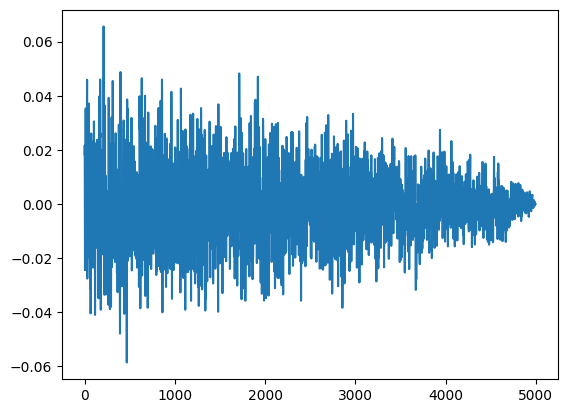

In [90]:
def autocorrelation(x):
    mean = np.mean(x)
    N = len(x)
    autocorrelation_lag = []
    c0 = 0
    for t in range(N):
        c0 = c0 + (x[t] - mean)* (x[t] - mean)
    c0 = (1/N) * c0
    for lag in range(1, N):
        c_lag = 0
        for t in range(N-lag):
            c_lag = c_lag + (x[t] - mean)* (x[t+lag] - mean)
        c_lag = (1/N) * c_lag
        autocorrelation_lag.append(c_lag/c0)
    return autocorrelation_lag
print(autocorrelation(x)[1:])
plt.plot(autocorrelation(x)[1:])

In [99]:
# Create the Lorenz dataset
lor_args = (10, 8/3, 28)
Z0 = (0, 1, 1.05)
h = 0.005
t_span = (0, 100)
t_eval, data = rk45(lorenz, t_span, Z0, h, lor_args)

# Define full data training and testing sizes
ndata  = len(data)
ntrain = 5000 
washout = 1000
ntest = ndata - ntrain

# Construct training input and teacher, testing input and teacher
training_input_orig = data[0:ntrain-1] 
training_teacher_orig = data[1:ntrain]
testing_input_orig = data[ntrain-1:ntrain+ntest-1]
testing_teacher_orig = data[ntrain:ntrain+ntest]

#training_input_orig = training_input_orig[:, 0].reshape((-1, 1))
#training_teacher_orig = training_teacher_orig[:, 0].reshape((-1, 1))
#testing_input_orig = testing_input_orig[:, 0].reshape((-1, 1))
#testing_teacher_orig = testing_teacher_orig[:, 0].reshape((-1, 1))

# Normalise the arrays for Volterra
normalisation_output = normalise_arrays([training_input_orig, training_teacher_orig, testing_input_orig, testing_teacher_orig], norm_type="ScaleL2Shift")
train_input, train_teacher, test_input, test_teacher = normalisation_output[0]
shift, scale = normalisation_output[1], normalisation_output[2]

ld_coef, tau_coef, reg, washout = 0.6, 0.4, 1e-09, 1000
volt = Volterra(ld_coef, tau_coef, reg, washout)
output = volt.Train(train_input, train_teacher).PathContinue(train_teacher[-1], test_teacher.shape[0])

In [112]:
# Create the Lorenz dataset
lor_args = (10, 8/3, 28)
Z0 = (0, 1, 1.05)
h = 0.005
t_span = (0, 100)
t_eval, data = rk45(lorenz, t_span, Z0, h, lor_args)

# Define full data training and testing sizes
ndata  = len(data)
ntrain = 5000 
washout = 1000
ntest = ndata - ntrain

# Construct training input and teacher, testing input and teacher
training_input_orig = data[0:ntrain-1] 
training_teacher_orig = data[1:ntrain]
testing_input_orig = data[ntrain-1:ntrain+ntest-1]
testing_teacher_orig = data[ntrain:ntrain+ntest]

#training_input_orig = training_input_orig[:, 0].reshape((-1, 1))
#training_teacher_orig = training_teacher_orig[:, 0].reshape((-1, 1))
#testing_input_orig = testing_input_orig[:, 0].reshape((-1, 1))
#testing_teacher_orig = testing_teacher_orig[:, 0].reshape((-1, 1))

# Normalise the arrays for Volterra
normalisation_output = normalise_arrays([training_input_orig, training_teacher_orig, testing_input_orig, testing_teacher_orig], norm_type="ScaleL2Shift")
train_input, train_teacher, test_input, test_teacher = normalisation_output[0]
shift, scale = normalisation_output[1], normalisation_output[2]

output = volt.PathContinue(train_teacher[-1], test_teacher.shape[0])

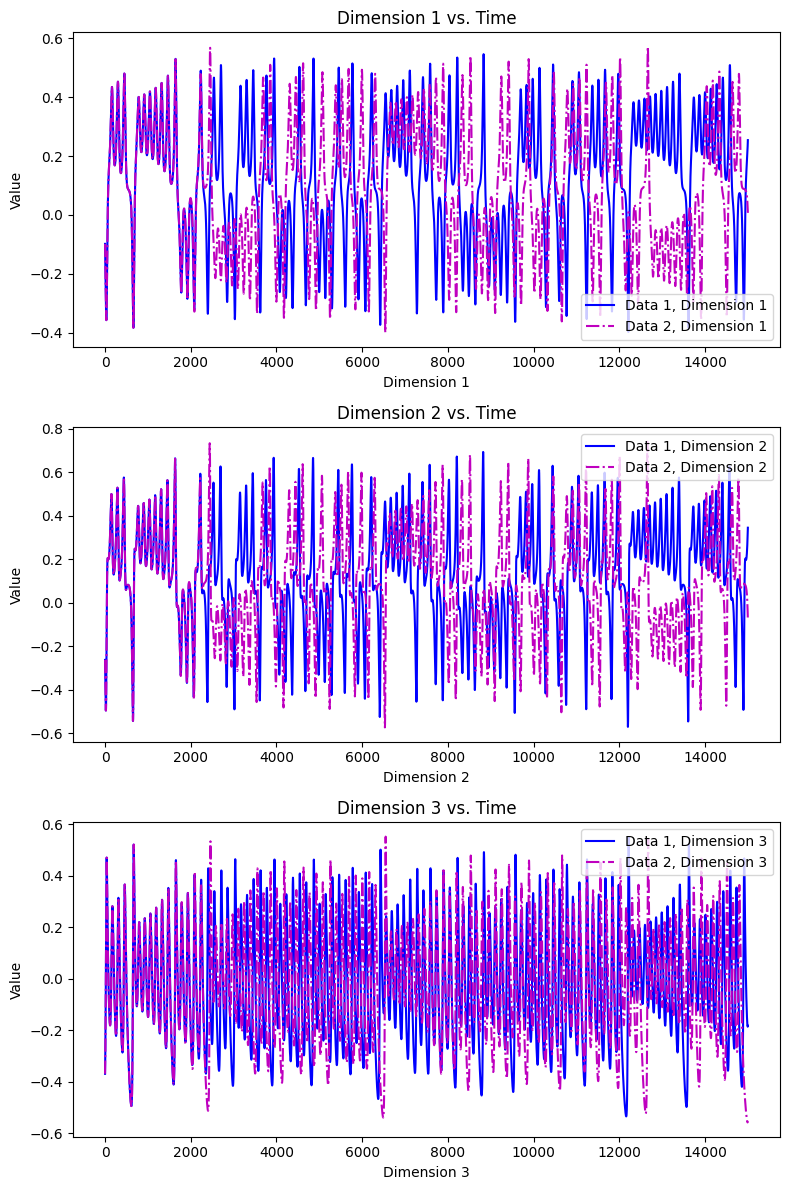

In [113]:
plot_data([output, test_teacher])

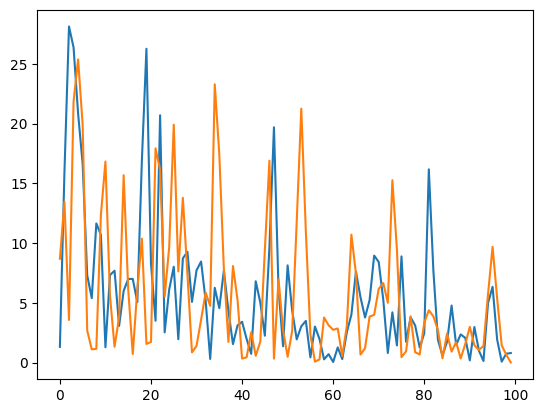

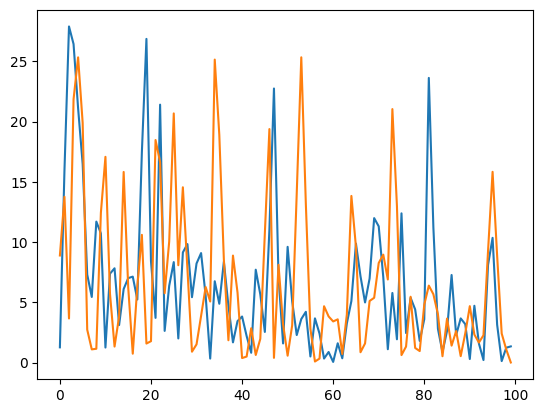

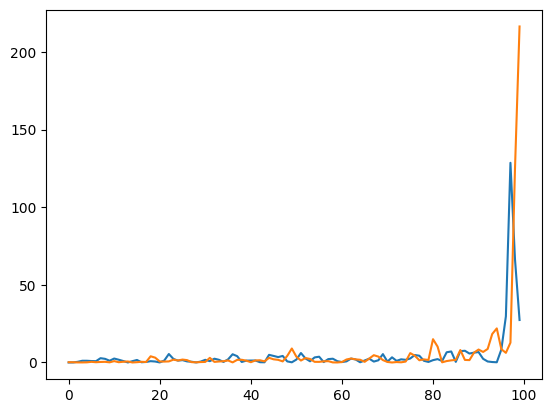

53.45217802792524

In [139]:
calculate_specdensloss(test_teacher, output)

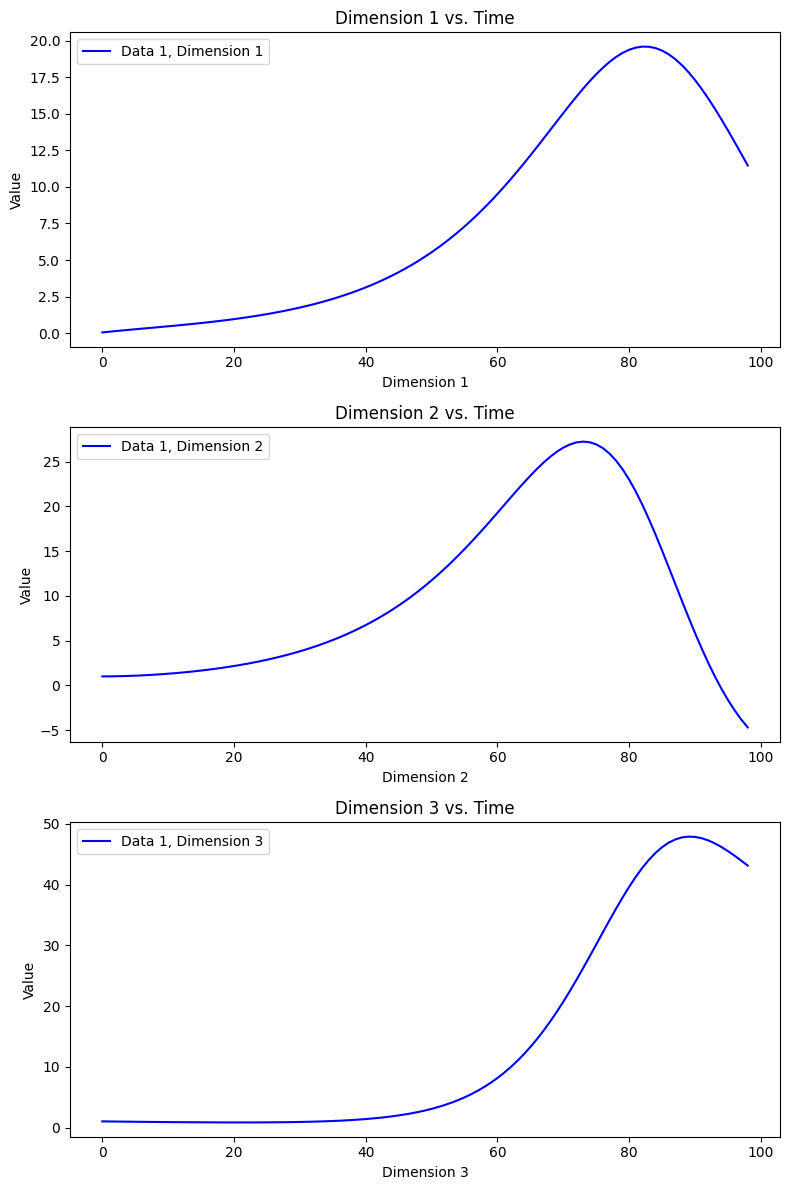

In [12]:
# Create the Lorenz dataset
lor_args = (10, 8/3, 28)
Z0 = (0, 1, 1.05)
h = 0.005
t_span = (0, 40)
t_eval, data = rk45(lorenz, t_span, Z0, h, lor_args)

# Define full data training and testing sizes
ndata  = len(data)
ntrain = 100 #5000 
washout = 0 #1000
ntest = ndata - ntrain

# Construct training input and teacher, testing input and teacher
training_input_orig = data[0:ntrain-1] 
training_teacher_orig = data[1:ntrain]
testing_input_orig = data[ntrain-1:ntrain+ntest-1]
testing_teacher_orig = data[ntrain:ntrain+ntest]
plot_data(training_teacher_orig)

In [37]:
# Create the Lorenz dataset
lor_args = (10, 8/3, 28)
Z0 = (0, 1, 1.05)
h = 0.005
t_span = (0, 40)
t_eval, data = rk45(lorenz, t_span, Z0, h, lor_args)

# Define full data training and testing sizes
ndata  = len(data)
ntrain = 5000 
washout = 1000
ntest = ndata - ntrain

# Construct training input and teacher, testing input and teacher
training_input_orig = data[0:ntrain-1] 
training_teacher_orig = data[1:ntrain]
testing_input_orig = data[ntrain-1:ntrain+ntest-1]
testing_teacher_orig = data[ntrain:ntrain+ntest]

training_input_orig = training_input_orig[:, 0].reshape((-1, 1))
training_teacher_orig = training_teacher_orig[:, 0].reshape((-1, 1))
testing_input_orig = testing_input_orig[:, 0].reshape((-1, 1))
testing_teacher_orig = testing_teacher_orig[:, 0].reshape((-1, 1))

# Normalise the arrays for Volterra
normalisation_output = normalise_arrays([training_input_orig, training_teacher_orig, testing_input_orig, testing_teacher_orig], norm_type="ScaleL2Shift")
train_input, train_teacher, test_input, test_teacher = normalisation_output[0]
shift, scale = normalisation_output[1], normalisation_output[2]

ld_coef, tau_coef, washout = 0.7, 0.5, washout
volt_opt= VolterraOptimisation(ld_coef, tau_coef, washout)
output_opt = volt_opt.Train(train_input, train_teacher).PathContinue(train_teacher[-1], test_teacher.shape[0])

In [38]:
output_opt

array([[1388.53796893],
       [ 937.82232699],
       [ 944.27981841],
       ...,
       [ 977.80200585],
       [ 977.80200585],
       [ 977.80200585]])